In [1]:
import sys
sys.path.insert(0, "../")

import os
os.chdir("../")

In [2]:
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import chex
import optax
from tqdm.autonotebook import tqdm
from functools import partial

from flow.distribution import make_equivariant_augmented_flow_dist
from target import double_well as dw
from utils.loggers import ListLogger

/tmp/ipykernel_112982/2825945601.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
USE_64_BIT = False
if USE_64_BIT:
    from jax.config import config
    config.update("jax_enable_x64", True)

In [4]:
from utils.plotting import plot_history
import matplotlib.pyplot as plt

In [5]:
def load_dataset(batch_size, train_test_split_ratio: float = 0.8, seed = 0):
    """Load dataset and add augmented dataset N(0, 1). """
    # Make length divisible by batch size also.

    dataset = np.load('target/data/dw_data_vertices2_dim2.npy')

    augmented_dataset = jnp.mean(dataset, axis=(1, 2), keepdims=True) + \
                        jax.random.normal(jax.random.PRNGKey(seed), shape=dataset.shape)
    dataset = jnp.concatenate((dataset, augmented_dataset), axis=-1)


    train_index = int(dataset.shape[0] * train_test_split_ratio)
    train_set = dataset[:train_index]
    test_set = dataset[train_index:]

    train_set = train_set[:-(train_set.shape[0] % batch_size)]
    test_set = test_set[:-(test_set.shape[0] % batch_size)]
    return train_set, test_set


@partial(jax.jit, static_argnums=(2,))
def eval(params, x, log_prob_fn,):
    log_prob = log_prob_fn.apply(params, x)
    info = {"eval_log_lik": jnp.mean(log_prob),
            "eval_kl": jnp.mean(dw.log_prob_fn(x) - log_prob)}
    return info


def loss_fn(params, x, log_prob_fn):
    log_prob = log_prob_fn.apply(params, x)
    loss = - jnp.mean(log_prob)
    info = {"loss": loss}
    return loss, info



@partial(jax.jit, static_argnums=(3, 4))
def step(params, x, opt_state, log_prob_fn, optimizer):
    grad, info = jax.grad(loss_fn, has_aux=True)(params, x, log_prob_fn)
    updates, new_opt_state = optimizer.update(grad, opt_state, params=params)
    new_params = optax.apply_updates(params, updates)
    info.update(grad_norm=optax.global_norm(grad))
    return new_params, new_opt_state, info


def plot_sample_hist(samples, ax):
    d = jnp.linalg.norm(samples[:, 0, :] - samples[:, 1, :], axis=-1)
    ax.hist(d, bins=50, density=True, alpha=0.4)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


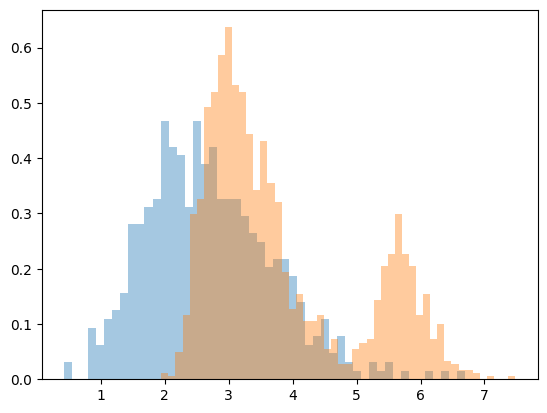

In [6]:
n_epoch = int(1e3)
max_global_norm = 100.0
dim = 2
lr = 4e-4
n_nodes = 2
n_layers = 8
batch_size = 32
mlp_units = (128, 128)
key = jax.random.PRNGKey(0)
flow_type = "vector_scale_shift"  # "nice", "proj", "vector_scale_shift"
identity_init = False if flow_type == "vector_scale_shift" else True

logger = ListLogger()


@hk.without_apply_rng
@hk.transform
def log_prob_fn(x):
    distribution = make_equivariant_augmented_flow_dist(
        dim=dim, nodes=n_nodes, n_layers=n_layers,
        flow_identity_init=identity_init, type=flow_type, mlp_units=mlp_units)
    return distribution.log_prob(x)

@hk.transform
def sample_and_log_prob_fn(sample_shape=()):
    distribution = make_equivariant_augmented_flow_dist(
        dim=dim, nodes=n_nodes, n_layers=n_layers,
        flow_identity_init=identity_init, type=flow_type, mlp_units=mlp_units)
    return distribution.sample_and_log_prob(seed=hk.next_rng_key(), sample_shape=sample_shape)

key, subkey = jax.random.split(key)
params = log_prob_fn.init(rng=subkey, x=jnp.zeros((1, n_nodes, dim*2)))

optimizer = optax.chain(optax.clip_by_global_norm(max_global_norm), optax.adam(lr))
opt_state = optimizer.init(params)

train_data, test_data = load_dataset(batch_size)

def plot():
    fig, ax = plt.subplots()
    samples = sample_and_log_prob_fn.apply(params, jax.random.PRNGKey(0), (512,))[0]
    plot_sample_hist(samples, ax)
    plot_sample_hist(train_data, ax)
    plt.show()

plot()

  0%|                                                                                                                                                                                                 | 0/1000 [00:00<?, ?it/s]

non numeric history values being saved


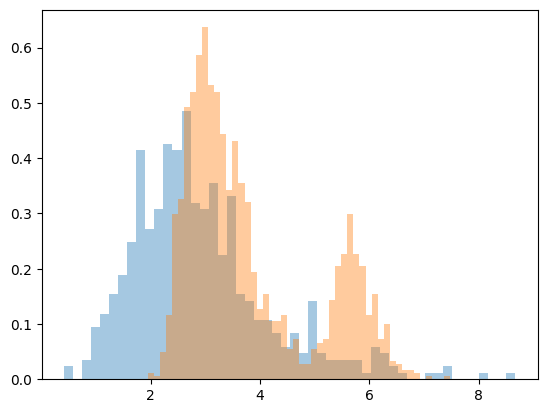

  1%|██                                                                                                                                                                                      | 11/1000 [00:34<52:03,  3.16s/it]


Exception: nan grad encountered

In [7]:
pbar = tqdm(range(n_epoch))
for i in pbar:
    for x in jnp.reshape(train_data, (-1, batch_size, *train_data.shape[1:])):
        params, opt_state, info = step(params, x, opt_state, log_prob_fn, optimizer)
        logger.write(info)
    if jnp.isnan(info["grad_norm"]):
        raise Exception("nan grad encountered")

    key, subkey = jax.random.split(key)
    train_data = jax.random.permutation(subkey, train_data, axis=0)
    if i % (n_epoch // 10) == 0:
        plot()
        eval_info = eval(params, test_data, log_prob_fn)
        logger.write(eval_info)


plot_history(logger.history)
plt.show()